### Observed distribution of read depths 

Let's plot the distribution of read depths from a pooled collection of individuals: 

/anaconda2/envs/tensorflow3/lib/python3.5/site-packages/matplotlib/axes/_base.py:3157: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


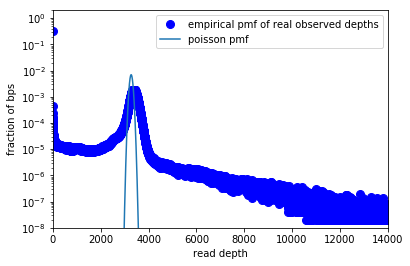

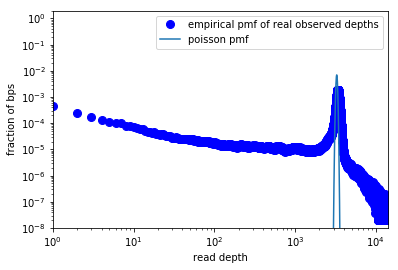

In [1]:
import numpy as np
from scipy.stats import poisson

from load_preprocess_data import compute_empirical_pmf
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline

scale = 3500

plot_max_depth = 4*scale
plot_min_prob = 1e-8
plot_max_prob = 2

def real_depths():
    return pd.DataFrame(data={'observed_depth': np.fromfile('../data/train_dev_data/100.multicov.bin', dtype=np.int32)})

def plot_distribution(depths, label, logx=False, plot_poisson=True): 
    pmf = compute_empirical_pmf(depths)
    ks = np.arange(len(pmf))
    figure = plt.figure()
    axis = figure.add_subplot(111)
    plot = axis.loglog if logx else axis.semilogy
    plot(ks, pmf, 'bo', ms=8, label=label)
    axis.set_xlabel('read depth')
    axis.set_ylabel('fraction of bps')
    if plot_poisson:
        plot(ks, poisson.pmf(ks, np.median(depths)), '-', label='poisson pmf')
    axis.set_xlim([0, plot_max_depth])
    axis.set_ylim([plot_min_prob, plot_max_prob])
    axis.legend()
    return axis

_ = plot_distribution(real_depths(), label='empirical pmf of real observed depths')
_ = plot_distribution(real_depths(), label='empirical pmf of real observed depths', logx=True)

Interestingly, the usual Poisson distribution of read depths appears to be superimposed upon a "background" distribution of read depths comprised of an exponential distribution (for depths greater than 100) and a power law distribution (for read depths less than 100). 



### Crude model of the observed read-depth distribution 

Let's ignore the "power law" background component and suppose that read depths are distributed according to the following mixture distribution: 

\begin{equation} 
p(k) = \sum_{i=1}^m p_{noise}(k \, | \, \lambda_i) \, p_{signal} (\lambda_i \, | \, s, \mu, \sigma)
\end{equation} 

where $p_{noise}(k \, | \, \lambda_i)$ is a Poisson distribution with mean $\lambda_i$ and 


\begin{equation} 
p_{signal}(\lambda_i\, | \, s, \mu, \sigma) = \alpha \, p_{exponential} (\lambda_i \, | \, s) + (1 - \alpha) \, p_{normal} (\lambda_i \, | \, \mu, \sigma)
\end{equation} 

where $p_{exponential} (\lambda_i \, | \, s)$ is an exponential distribution with scale parameter $s$ and 
$p_{normal} (\lambda_i \, | \, \mu, \sigma)$ is a normal distribution with mean $\mu$ and standard deviation 
$\sigma$. 

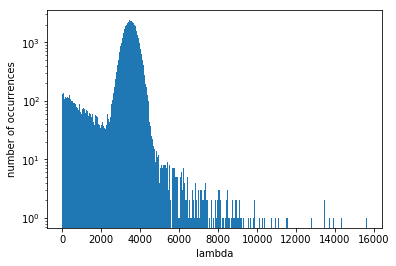

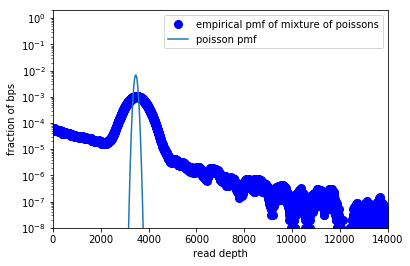

In [2]:
def sample_lambdas(number_of_lambdas=100000, alpha=0.1, s=0.5, mu=1.0, sigma=0.1): 
    s *= scale 
    mu *= scale 
    sigma *= scale
    number_of_lambdas_from_exponential = int(np.random.binomial(n=number_of_lambdas, p=alpha, size=1))
    lambdas_exponential = np.random.exponential(scale=s, size=number_of_lambdas_from_exponential)    
    number_of_lambdas_from_normal = number_of_lambdas - number_of_lambdas_from_exponential
    lambdas_normal = np.random.normal(loc=mu, scale=sigma, size=number_of_lambdas_from_normal)
    return np.concatenate((lambdas_exponential, lambdas_normal))
    
_ = plt.hist(sample_lambdas(), bins='auto')
_ = plt.xlabel('lambda')
_ = plt.ylabel('number of occurrences')
plt.yscale('log')

def sample_from_mixture_distribution():    
    lambdas = sample_lambdas()
    lambdas = lambdas[lambdas >= 0]
    # https://github.com/numpy/numpy/issues/7843 ...
    depths = np.random.poisson(lam = lambdas[:, np.newaxis], size=(len(lambdas), 1000)) 
    return pd.DataFrame(data={'observed_depth': depths.flatten()})

_ = plot_distribution(sample_from_mixture_distribution(), label='empirical pmf of mixture of poissons')

Not a bad approximation of the real depth data! 

### Re-sampling the observed data 

Mixing Poisson distributions adds weight to the tails of a pure Poisson distribution, i.e., bps with abnormally high or low read depths result from draws from Poisson distributions with abnormally low or high rate parameters. We should feed such anomalous examples to a machine learning algorithm if it is to learn a mapping from sequence to read-depth rate parameters other than the trivial one in which every sequence is mapped to the mean genome-wide depth. But we would also want to feed examples that sit in the bulk of the distribution so that the algorithm learns to map those sequences to rate parameters in the vicinity of the genome-wide mean depth. 


How can we re-sample our data set such that bps with unusually low or high depths appear as frequently as those with depths closer to the mean? In other words, how can we produce a sub-sample in which all depths occur equally frequently? 

A general and easy-to-implement approach is to use [rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling#Algorithm). In this algorithm, for each example (bp) in the original sample, one makes it a member of the new sample with probability $p_{target}(k)/Mp(k)$ where $k$ is the read depth associated with the example, $M$ is the fold-change reduction in sample size, and $p_{target}$ is the new distribution from which the resampled data are to be drawn. 





### Uniform sampling 

For example, to make the resampled data uniformly distributed over the interval $[0, d]$, choose 

\begin{equation} 
p_{target}(k) = \left\{ \begin{array}{ll}
 1/d & \mbox{if $k \leq d$}\\
 0 & \mbox{if $k > d$}.
 \end{array} \right.
\end{equation} 

/Users/petermchale/Work/denoising_coverage_profiles/application/load_preprocess_data.py:43: RuntimeWarning: invalid value encountered in true_divide
  return target_distribution / (args.fold_reduction_of_sample_size * proposal_distribution)
/anaconda2/envs/tensorflow3/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


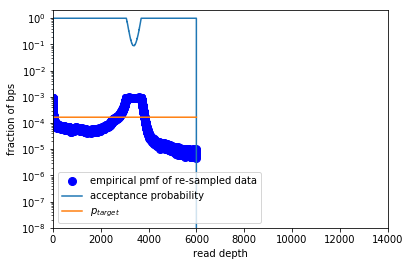

In [3]:
from load_preprocess_data import compute_acceptance_probability 

def plot_acceptance_probability(depths, args): 
    acceptance_prob = compute_acceptance_probability(depths, args)
    acceptance_prob[acceptance_prob > 1.0] = 1.0
    ks = np.arange(len(acceptance_prob))
    plt.plot(ks, acceptance_prob, label='acceptance probability')
    plt.legend()

from utility import named_tuple
from load_preprocess_data import resample

def plot_resampled_distribution(depths, fold_reduction_of_sample_size=1, resampling_target=None, title=False):
    args = named_tuple({'fold_reduction_of_sample_size': fold_reduction_of_sample_size, 
                        'resampling_target': resampling_target})
    new_depths = resample(depths, args) 
    plt.figure()
    new_empirical_pmf = compute_empirical_pmf(new_depths)
    ks = np.arange(len(new_empirical_pmf))
    plt.semilogy(ks, new_empirical_pmf, 'bo', ms=8, label='empirical pmf of re-sampled data')
    plt.xlim([0, plot_max_depth])
    plt.ylim([plot_min_prob, plot_max_prob])
    plt.xlabel('read depth')
    plt.ylabel('fraction of bps')
    if title:
        plt.title('new sample size: {}; original sample size: {}'.format(len(new_depths), len(depths)))
    if resampling_target: 
        plot_acceptance_probability(depths, args)   
        plt.plot(ks, resampling_target.function(ks, resampling_target), label='$p_{target}$' )
    plt.legend()

from load_preprocess_data import uniform_distribution
uniform_distribution_params = named_tuple({'function': uniform_distribution, 'd': 6000})

plot_resampled_distribution(real_depths(), resampling_target=uniform_distribution_params)

Notice that the empirical distribution of the re-sampled data does not quite match that of the target distribution. For base pairs where the acceptance probability saturates at one, one does not sub-sample, and so it is impossible to create a local distribution other than the original local distribution. To avoid saturating the acceptance probability, one may increase the fold-change reduction in sample size:



/Users/petermchale/Work/denoising_coverage_profiles/application/load_preprocess_data.py:43: RuntimeWarning: invalid value encountered in true_divide
  return target_distribution / (args.fold_reduction_of_sample_size * proposal_distribution)
/anaconda2/envs/tensorflow3/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


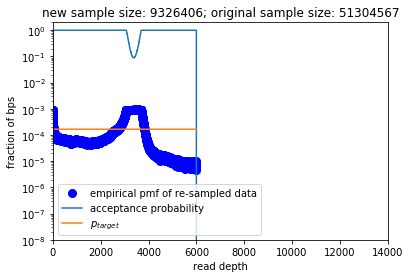

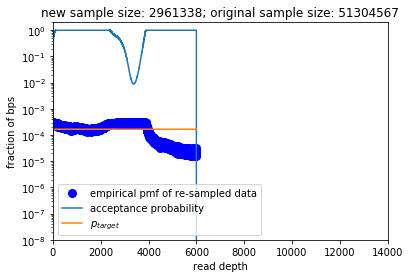

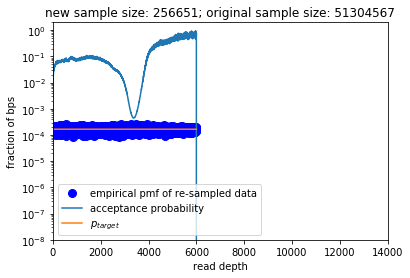

In [4]:
plot_resampled_distribution(real_depths(), fold_reduction_of_sample_size=1e0, resampling_target=uniform_distribution_params, title=True)
plot_resampled_distribution(real_depths(), fold_reduction_of_sample_size=1e1, resampling_target=uniform_distribution_params, title=True)
plot_resampled_distribution(real_depths(), fold_reduction_of_sample_size=2e2, resampling_target=uniform_distribution_params, title=True)

### Sampling the tails of the observed read-depth distribution 

Suppose now that we wish to sample all base pairs with depths below and above some threshold values, and no base pairs with depths in between...

/Users/petermchale/Work/denoising_coverage_profiles/application/load_preprocess_data.py:43: RuntimeWarning: invalid value encountered in true_divide
  return target_distribution / (args.fold_reduction_of_sample_size * proposal_distribution)
/anaconda2/envs/tensorflow3/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


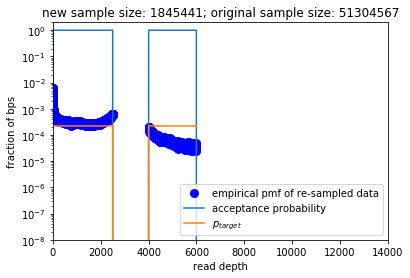

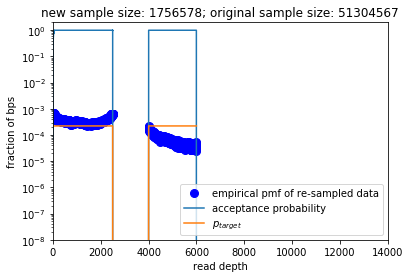

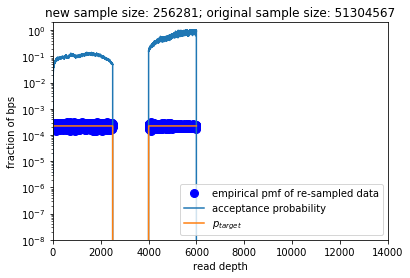

In [5]:
from load_preprocess_data import humped_distribution
humped_distribution_params = named_tuple({'function': humped_distribution, 'd1': 2500, 'd2': 4000, 'd3': 6000, 'c': 0.00022222222222222223})

plot_resampled_distribution(real_depths(), fold_reduction_of_sample_size=1e0, title=True, resampling_target=humped_distribution_params)
plot_resampled_distribution(real_depths(), fold_reduction_of_sample_size=1e1, title=True, resampling_target=humped_distribution_params)
plot_resampled_distribution(real_depths(), fold_reduction_of_sample_size=2e2, title=True, resampling_target=humped_distribution_params)